In [2]:
import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.cosmology import Planck15
from scipy.special import sph_harm_y
import pint
from pint.models import get_model
import glob, os #glob2
from astropy import units as u
from astropy.coordinates import SkyCoord

from gwbird.pta import pta_dir
from gwbird.skymap import Basis, PolarizationTensors

cosmo = Planck15
H0 =  cosmo.H0.to('1/s').value
h = 0.7
plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

# Catalog

Catalog EPTA

In [59]:
def get_pulsars_EPTA():
    name, phi, theta, ntoas, Tspan, wn, log10_A_red, g_red, log10_A_dm, g_dm, log10_A_sv, g_sv, dt = np.genfromtxt('gwbird/EPTA/epta.txt', unpack=True, skip_header=True, delimiter=None)

    x_pulsar = np.sin(theta) * np.cos(phi)
    y_pulsar = np.sin(theta) * np.sin(phi)
    z_pulsar = np.cos(theta)
    pulsar_xyz = np.array([x_pulsar, y_pulsar, z_pulsar]).T

    return pulsar_xyz, wn, dt


# Overlap for all the pulsar pairs

In [60]:
def pairwise_overlap(f, pi, pj):
    def F(theta, phi, psi, p): # https://arxiv.org/pdf/1306.5394, https://arxiv.org/abs/2407.14460
        '''
        Compute the antenna pattern functions for a given direction of the source and polarization angle psi
        
        Parameters:
        theta, phi: angles of the source
        psi: polarization angle
        p: unit vector of the pulsar [x, y, z]
        '''
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
        e_plus, e_cross, e_x, e_y, e_b, e_l  = PolarizationTensors.e_pol(theta, phi, psi)
        #print('shape e ', e_plus.shape)
        F_plus = np.einsum('ijkl, klij ->kl ', D, e_plus)
        F_cross = np.einsum('ijkl, klij ->kl', D, e_cross) 
        F_x = np.einsum('ijkl, klij ->kl', D, e_x)
        F_y = np.einsum('ijkl, klij ->kl', D, e_y)
        F_b = np.einsum('ijkl, klij ->kl', D, e_b)
        F_l = np.einsum('ijkl, klij ->kl', D, e_l) 
        return F_plus, F_cross, F_x, F_y, F_b, F_l


    def gamma_integrand(theta, phi, psi, p1, p2):
        Fp1 = F(theta, phi, psi, p1)
        Fp2 = F(theta, phi, psi, p2)
        gamma_ij = 3/ 2 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1]) * (1/(4*np.pi)) * np.sin(theta)
        return gamma_ij

    def gamma(p1, p2, f):
        theta = np.linspace(0, np.pi, 100)
        phi = np.linspace(0, 2*np.pi, 100)
        Theta, Phi = np.meshgrid(theta, phi)
        integrand = gamma_integrand(Theta, Phi, 0, p1, p2)
        integral = np.trapezoid(np.trapezoid(integrand, theta), phi)
        return np.abs(integral)

    return gamma(pi, pj, f)
    

In [61]:
def overlap_PTA(f):

    '''

    Compute the overlap reduction function for a set of pulsars

    parameters:
    f: frequency array

    return:
    overlap: overlap reduction function for a set of pulsars

    '''


        
    def F(theta, phi, psi, p): # https://arxiv.org/pdf/1306.5394, https://arxiv.org/abs/2407.14460
        '''
        Compute the antenna pattern functions for a given direction of the source and polarization angle psi
        
        Parameters:
        theta, phi: angles of the source
        psi: polarization angle
        p: unit vector of the pulsar [x, y, z]
        '''
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
        e_plus, e_cross, e_x, e_y, e_b, e_l  = PolarizationTensors.e_pol(theta, phi, psi)
        #print('shape e ', e_plus.shape)
        F_plus = np.einsum('ijkl, klij ->kl ', D, e_plus)
        F_cross = np.einsum('ijkl, klij ->kl', D, e_cross) 
        F_x = np.einsum('ijkl, klij ->kl', D, e_x)
        F_y = np.einsum('ijkl, klij ->kl', D, e_y)
        F_b = np.einsum('ijkl, klij ->kl', D, e_b)
        F_l = np.einsum('ijkl, klij ->kl', D, e_l) 
        return F_plus, F_cross, F_x, F_y, F_b, F_l


    def gamma_integrand(theta, phi, psi, p1, p2):
        Fp1 = F(theta, phi, psi, p1)
        Fp2 = F(theta, phi, psi, p2)
        gamma_ij = 3/ 2 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1]) * (1/(4*np.pi)) * np.sin(theta)
        return gamma_ij

    def gamma(p1, p2, f):
        theta = np.linspace(0, np.pi, 100)
        phi = np.linspace(0, 2*np.pi, 100)
        Theta, Phi = np.meshgrid(theta, phi)
        integrand = gamma_integrand(Theta, Phi, 0, p1, p2)
        integral = np.trapezoid(np.trapezoid(integrand, theta), phi)
        return np.abs(integral)


    pulsar_xyz, _, _ = get_pulsars_EPTA()
    N_pulsar = len(pulsar_xyz)

    print('Number of pulsars: ', N_pulsar)
    N_pair = 0
    overlap = np.zeros(len(f))

    for i in range(N_pulsar):
        for j in range(i +1, N_pulsar):
            N_pair += 1
            overlap += gamma( pulsar_xyz[i], pulsar_xyz[j], f)
    
    print('Number of pairs: ', N_pair)
    return overlap

In [62]:
overlap = overlap_PTA(np.linspace(1e-9, 1e-7, 100))

print('Overlap: ', overlap)

Number of pulsars:  25
Number of pairs:  300
Overlap:  [44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916
 44.68528916 44.68528916 44.68528916 44.68528916 44.68528916 44.68528

# Sensitivity Curve

In [53]:
def pls_PTA(f, snr, Tobs):

    '''
    Compute the power law sensitivity curve for PTA

    parameters:
    f: frequency array
    snr: signal to noise ratio
    Tobs: observation time in years

    return:
    pls: power law sensitivity curve

    '''


    def PTA_Pn(wn, dt):
        return 2 * (wn**2) * dt * 1e-12


    def PTA_Sn(f, wn, dt):
        f = np.asarray(f) # Ensure f is a NumPy array
        mask = f >= 8e-9 # Create a boolean mask where True indicates elements greater than or equal to 8e-9
        return np.where(mask, PTA_Pn(wn, dt) * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result

    def PTA_Seff(f, pi, pj, wni, wnj, dti, dtj):
        overlap = pairwise_overlap(f, pi, pj)
        return (overlap)**-0.5 * np.sqrt(PTA_Sn(f, wni, dti)* PTA_Sn(f, wnj, dtj))
    
    def PTA_Omegaeff(f,pi, pj, wni, wnj, dti, dtj ):
        return 2 * np.pi * np.pi * f**3 *  PTA_Seff(f, pi, pj, wni, wnj, dti, dtj) / (3* (H0**2))
    
    def PTA_Omegaeff_all(f, p, wn, dt):
        s = 0
        N = len(p)
        for i in range(N):
            for j in range(i+1, N):
                s +=  pairwise_overlap(f, p[i], p[j])**2 / (PTA_Sn(f, wn[i], dt[i])* PTA_Sn(f, wn[j], dt[j]))

        return 2 * np.pi * np.pi * f**3 / np.sqrt(s) / (3* (H0**2))
    

    def Omega_beta_PTA(f, snr, Tobs, beta, p, wn, dt):
        Tobs = Tobs*365*24*3600
        fref = 1e-8
        integrand = ((f/fref)**(2*beta))/ (PTA_Omegaeff_all(f, p, wn, dt)**2)
        integral = np.trapezoid(integrand, f)
        return snr / np.sqrt(2*Tobs*integral)


    def Omega_GW_PTA(f,  beta, fref, snr, Tobs,  p, wn, dt):
        return Omega_beta_PTA(f, snr, Tobs, beta, p, wn, dt) * ((f/fref)**(beta))

    def all_Omega_GW_PTA(f, snr, Tobs, p, wn, dt):
        beta = np.linspace(-8, 8, 50)
        fref = 1e-8
        Omega = []
        for i in range(len(beta)):
            Omega.append(Omega_GW_PTA(f, beta[i], fref, snr, Tobs, p, wn, dt))     
        return beta, np.array(Omega)
    
    p, wn, dt = get_pulsars_EPTA()
    beta, Omega = all_Omega_GW_PTA(f, snr, Tobs,  p, wn, dt)
    pls = np.zeros(len(f))
    for i in range(len(f)):
        pls[i] = np.max(Omega[:,i])
    return pls

In [8]:
f = np.logspace(-9, -7, 100)
Tobs = 20
snr = 1

pls = pls_PTA(f, snr, Tobs)

print('pls', pls)

pls [1.37229336e-02 9.45868584e-03 6.51950525e-03 4.49364208e-03
 3.09729318e-03 2.13484405e-03 1.47146519e-03 1.01422388e-03
 6.99065178e-04 4.81838511e-04 3.32112595e-04 2.28912329e-04
 1.57780389e-04 1.08751902e-04 7.49584677e-05 5.16659642e-05
 3.56113450e-05 2.45455188e-05 1.69182740e-05 1.16611100e-05
 8.03755079e-06 5.53997199e-06 3.81848780e-06 2.63193552e-06
 1.81409106e-06 1.25038260e-06 8.61840226e-07 5.94033037e-07
 4.09443930e-07 2.82213819e-07 1.94519038e-07 1.34074428e-07
 9.24123025e-08 6.36962155e-08 4.39033306e-08 3.02608628e-08
 2.08576389e-08 1.43763614e-08 9.90906829e-09 6.82993640e-09
 4.70761023e-09 3.24477313e-09 2.23649625e-09 1.54153011e-09
 1.06251691e-09 7.32351693e-10 5.44430540e-10 5.16737077e-10
 5.37466954e-10 5.84023395e-10 6.50730960e-10 7.37956120e-10
 8.47344748e-10 9.78875893e-10 1.14552764e-09 1.34359891e-09
 1.57941852e-09 1.88086607e-09 2.23984786e-09 2.66734485e-09
 3.17643385e-09 3.83757167e-09 4.63995453e-09 5.61010449e-09
 6.78309931e-09 8.20

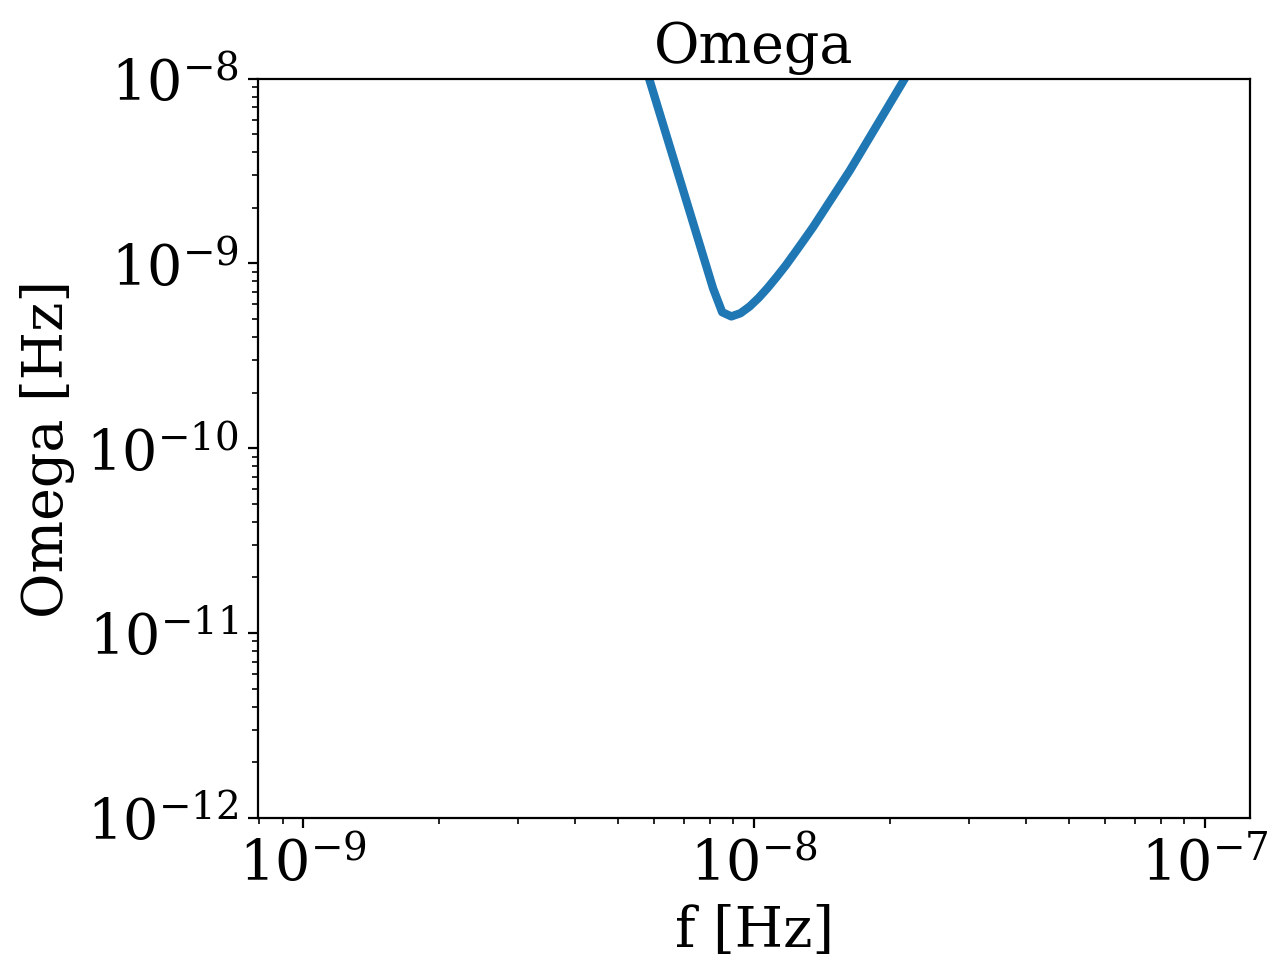

In [10]:
plt.loglog(f, pls)
plt.xlabel('f [Hz]')
plt.ylabel('Omega [Hz]')
plt.title('Omega')
plt.ylim(1e-12, 1e-8)
plt.show()


In [11]:
print(np.min(pls))

5.167370773984395e-10


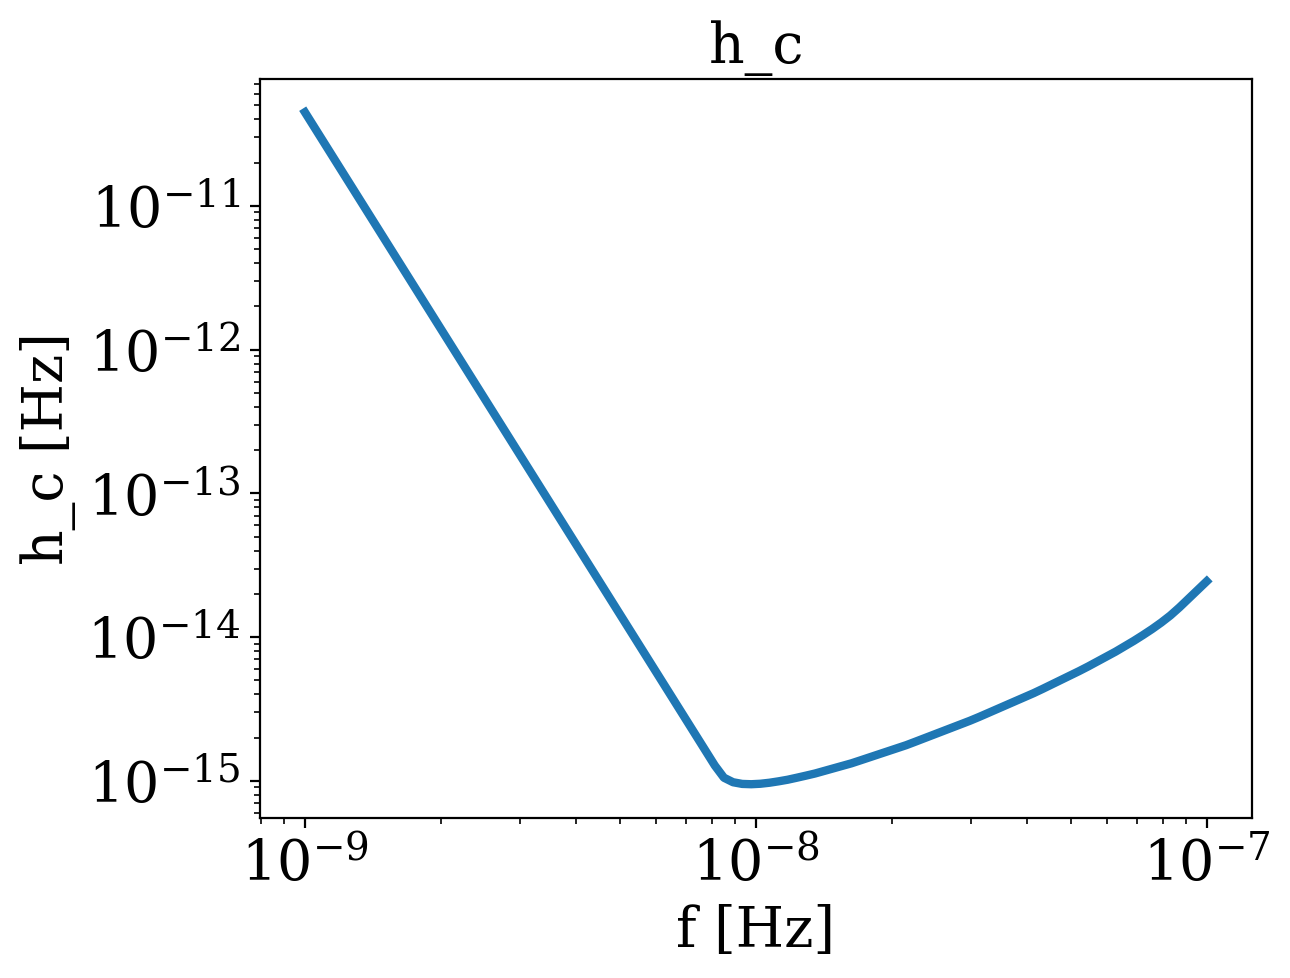

In [12]:
h_c_sens = np.sqrt(3 * H0**2 * pls / (10 * np.pi**2 * f**2))

plt.plot(f, h_c_sens)
plt.xlabel('f [Hz]')
plt.ylabel('h_c [Hz]')
plt.title('h_c')
plt.xscale('log')
plt.yscale('log')

# Angular response

In [39]:
def angular_response_pairwise(ell, pi, pj, f):
    
    def F(theta, phi, psi, p): # https://arxiv.org/pdf/1306.5394, https://arxiv.org/abs/2407.14460
        '''
        Compute the antenna pattern functions for a given direction of the source and polarization angle psi
        
        Parameters:
        theta, phi: angles of the source
        psi: polarization angle
        p: unit vector of the pulsar [x, y, z]
        '''
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
        e_plus, e_cross, e_x, e_y, e_b, e_l  = PolarizationTensors.e_pol(theta, phi, psi)
        #print('shape e ', e_plus.shape)
        F_plus = np.einsum('ijkl, klij ->kl ', D, e_plus)
        F_cross = np.einsum('ijkl, klij ->kl', D, e_cross) 
        F_x = np.einsum('ijkl, klij ->kl', D, e_x)
        F_y = np.einsum('ijkl, klij ->kl', D, e_y)
        F_b = np.einsum('ijkl, klij ->kl', D, e_b)
        F_l = np.einsum('ijkl, klij ->kl', D, e_l) 
        return F_plus, F_cross, F_x, F_y, F_b, F_l

    def gamma_integrand_ellm(ell, m, theta, phi, psi, p1, p2):
        Fp1 = F(theta, phi, psi, p1)
        Fp2 = F(theta, phi, psi, p2)
        gamma_ij = 3/ 2 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1]) * (1/(4*np.pi)) * np.sin(theta) * np.sqrt(4*np.pi) * sph_harm_y(ell, m, theta, phi)
        return gamma_ij

    def gamma_ellm(ell, m, p1, p2, f):
        theta = np.linspace(0, np.pi, 100)
        phi = np.linspace(0, 2*np.pi, 100)
        Theta, Phi = np.meshgrid(theta, phi)
        integrand = gamma_integrand_ellm(ell, m, Theta, Phi, 0, p1, p2)
        integral = np.trapezoid(np.trapezoid( integrand, theta), phi)
        return np.real(integral)
    
    def gamma_ell(ell, p1, p2, f):
        gamma_l = 0
        for m in range(-ell, ell+1):
            gamma_l += np.abs(gamma_ellm(ell, m, p1, p2, f))**2
        return np.sqrt(gamma_l)

    return gamma_ell(ell, pi, pj, f)


In [47]:
R0_all = 0
p = get_pulsars_EPTA()[0]
for i in range(len(p)):
    for j in range(i+1, len(p)):
        R0_all += angular_response_pairwise(0, p[i], p[j], f)

In [50]:
def angular_response_PTA(ell, f):

    '''

    Compute the overlap reduction function for a set of pulsars

    parameters:
    ell: multipole
    f: frequency array

    return:
    angular respone: angular response for a set of pulsars

    '''

        
    def F(theta, phi, psi, p): # https://arxiv.org/pdf/1306.5394, https://arxiv.org/abs/2407.14460
        '''
        Compute the antenna pattern functions for a given direction of the source and polarization angle psi
        
        Parameters:
        theta, phi: angles of the source
        psi: polarization angle
        p: unit vector of the pulsar [x, y, z]
        '''
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
        e_plus, e_cross, e_x, e_y, e_b, e_l  = PolarizationTensors.e_pol(theta, phi, psi)
        F_plus = np.einsum('ijkl, klij ->kl ', D, e_plus)
        F_cross = np.einsum('ijkl, klij ->kl', D, e_cross) 
        F_x = np.einsum('ijkl, klij ->kl', D, e_x)
        F_y = np.einsum('ijkl, klij ->kl', D, e_y)
        F_b = np.einsum('ijkl, klij ->kl', D, e_b)
        F_l = np.einsum('ijkl, klij ->kl', D, e_l) 
        return F_plus, F_cross, F_x, F_y, F_b, F_l
        
    def gamma_integrand_ellm(ell, m, theta, phi, psi, p1, p2):
        Fp1 = F(theta, phi, psi, p1)
        Fp2 = F(theta, phi, psi, p2)
        gamma_ij = 3/ 2 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1]) * (1/(4*np.pi)) * np.sin(theta) * np.sqrt(4*np.pi) * sph_harm_y(ell, m, theta, phi)
        return gamma_ij

    def gamma_ellm(ell, m, p1, p2, f):
        theta = np.linspace(0, np.pi, 100)
        phi = np.linspace(0, 2*np.pi, 100)
        Theta, Phi = np.meshgrid(theta, phi)
        integrand = gamma_integrand_ellm(ell, m, Theta, Phi, 0, p1, p2)
        integral = np.trapezoid(np.trapezoid( integrand, theta), phi)
        return np.real(integral)
    
    def gamma_ell(ell, p1, p2, f):
        gamma_l = 0
        for m in range(-ell, ell+1):
            gamma_l += np.abs(gamma_ellm(ell, m, p1, p2, f))**2
        return np.sqrt(gamma_l)
    

    pulsar_xyz, _, _ = get_pulsars_EPTA()
    N_pulsar = len(pulsar_xyz)
    print('Number of pulsars ', N_pulsar)
    
    angular_response = np.zeros(len(f))

    for i in range(N_pulsar):
        for j in range(i+1, N_pulsar):
            angular_response += gamma_ell(ell, pulsar_xyz[i], pulsar_xyz[j], f)
            
    return angular_response

In [51]:
f = np.logspace(-9, -7, 100)
R0 = angular_response_PTA(0, f)
R1 = angular_response_PTA(1, f)
R2 = angular_response_PTA(2, f)

Number of pulsars  25
Number of pulsars  25
Number of pulsars  25


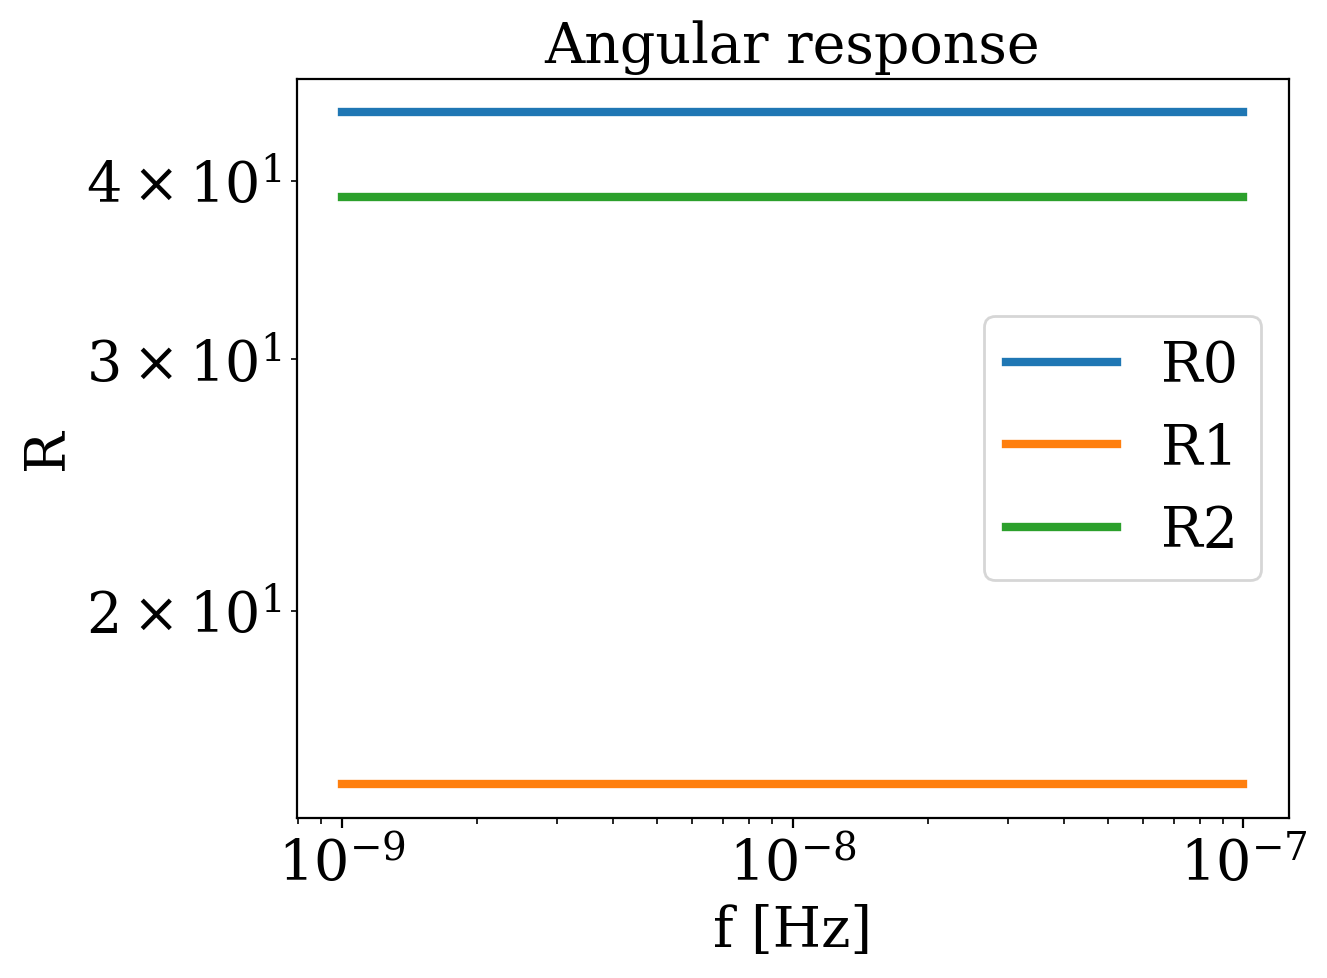

In [37]:
plt.loglog(f, R0, label = 'R0')
plt.loglog(f, R1, label = 'R1')
plt.loglog(f, R2, label = 'R2')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.title('Angular response')
plt.legend()

# Angular Sensitivity

In [54]:

def apls_PTA(ell, f, snr, Tobs, Cl):

    '''
    Compute the power law sensitivity curve for PTA

    parameters:
    ell: multipole, integer
    f: frequency array
    snr: signal to noise ratio
    Tobs: observation time in years
    Cl (float): Cl parameter for multipole.

    return:
    pls: power law sensitivity curve

    '''

    def PTA_Pn(wn, dt):
        return 2 * (wn**2) * dt * 1e-12

    def PTA_Sn(f, wn, dt):
        f = np.asarray(f) # Ensure f is a NumPy array
        mask = f >= 8e-9 # Create a boolean mask where True indicates elements greater than or equal to 8e-9
        return np.where(mask, PTA_Pn(wn, dt) * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result
    
    def PTA_Omegaeff_all(ell, f, p, wn, dt):
        s = 0
        N = len(p)
        for i in range(N):
            for j in range(i+1, N):
                s +=  angular_response_pairwise(ell, p[i], p[j], f)**2 / (PTA_Sn(f, wn[i], dt[i])* PTA_Sn(f, wn[j], dt[j]))

        return 2 * np.pi * np.pi * f**3 / np.sqrt(s) / (3* (H0**2))
    

    def Omega_beta_PTA(ell, f, snr, Tobs, Cl, beta, p, wn, dt):
        Tobs = Tobs*365*24*3600
        fref = 1e-8
        integrand = ((f/fref)**(2*beta))/ (PTA_Omegaeff_all(ell, f, p, wn, dt)**2) * Cl
        integral = np.trapezoid(integrand, f)
        return snr / np.sqrt(2*Tobs*integral)

    def Omega_GW_PTA(ell, f,  beta, fref, snr, Tobs, Cl,  p, wn, dt):
        return Omega_beta_PTA(ell, f, snr, Tobs, Cl, beta, p, wn, dt) * ((f/fref)**(beta))

    def all_Omega_GW_PTA(ell, f, snr, Tobs, Cl, p, wn, dt):
        beta = np.linspace(-8, 8, 50)
        fref = 1e-8
        Omega = []
        for i in range(len(beta)):
            Omega.append(Omega_GW_PTA(ell, f, beta[i], fref, snr, Tobs, Cl, p, wn, dt))     
        return beta, np.array(Omega)
    
    p, wn, dt = get_pulsars_EPTA()
    beta, Omega = all_Omega_GW_PTA(ell, f, snr, Tobs, Cl, p, wn, dt)
    pls = np.zeros(len(f))
    for i in range(len(f)):
        pls[i] = np.max(Omega[:,i])
    return pls

In [55]:
Tobs = 20
snr = 1
apls_0 = apls_PTA(0, f, snr, Tobs, 1)

Text(0, 0.5, 'Omega [Hz]')

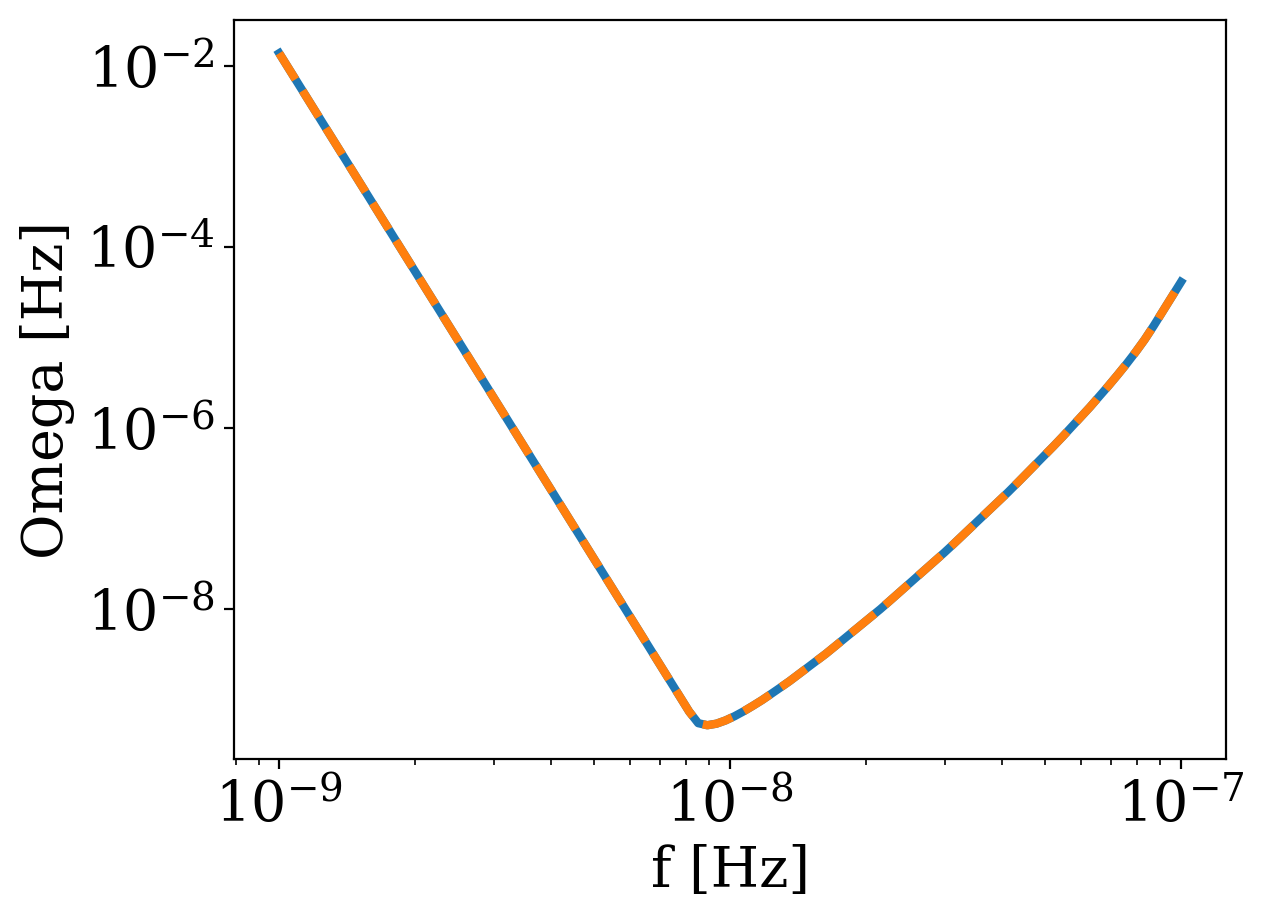

In [56]:
plt.loglog(f, apls_0, label = 'apl0')
plt.loglog(f, pls, label = 'pls0', linestyle='--')
plt.xlabel('f [Hz]')
plt.ylabel('Omega [Hz]')